In [297]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from dataclasses import replace
from functools import partial

from copy import deepcopy, copy

import vtk
from vtk.util import numpy_support

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

from rattlers import *

In [341]:
def calculate_packing_fraction(state, system):
    return jnp.sum(state.volume) / jnp.prod(system.domain.box_size)

def jax_copy(x):
    return jax.tree.map(lambda y: y, x)

def scale_by_packing_fraction_offset(state, system, offset, copy=False):
    """
    Scale the state and system to packing fraction + offset.
    Optionally return a copy of the state and system.
    """
    if copy:
        new_state = jax_copy(state)
        new_system = jax_copy(system)
    else:
        new_state = state
        new_system = system

    packing_fraction = calculate_packing_fraction(new_state, new_system)
    scale = (packing_fraction / (packing_fraction + offset)) ** (1 / state.dim)
    new_state.pos_c *= scale
    new_system.domain.box_size *= scale
    return new_state, new_system

def calculate_kinetic_energy(state):
    """
    Calculate the kinetic energy for each particle.
    """
    ke_t = 0.5 * state.mass * jnp.sum(state.vel ** 2, axis=-1)
    ke_r = 0.5 * jnp.sum(state.inertia * state.angVel ** 2, axis=-1)
    return ke_t + ke_r

def dof_disk(state):  # TODO: account for state.fixed!
    return state.dim * state.N

def dof_rod(state):  # TODO: account for state.fixed!
    return state.dim * state.N + state.inertia.shape[1] * state.N

def dof_rigid_clump(state):  # TODO: account for state.fixed!
    N_clumps = jnp.max(state.ID) + 1
    return state.dim * N_clumps + state.inertia.shape[1] * N_clumps

def calculate_temperature(state, dof_func):
    ke = jnp.sum(calculate_kinetic_energy(state))
    return 2 * ke / dof_func(state)

def set_temperature(state, target_temperature, seed, dof_func, subtract_mean_velocities=True):
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    state.vel = jax.random.normal(key_vel, state.vel.shape)
    if subtract_mean_velocities:
        state.vel -= jnp.mean(state.vel, axis=0)
    state.angVel = jax.random.normal(key_angVel, state.angVel.shape)
    temperature = calculate_temperature(state, dof_func)
    scale = jnp.sqrt(target_temperature / temperature)
    state.vel *= scale
    state.angVel *= scale
    temperature = calculate_temperature(state, dof_func)
    assert jnp.isclose(temperature, target_temperature)
    return state

In [342]:
# build a set of states and systems using vmap

N_systems = 1
N = 10
phi = 0.4
dim = 2
e_int = 1.0
dt = 1e-2

def build_microstate(i):
    # assign bidisperse radii
    rad = jnp.ones(N)
    rad = rad.at[: N // 2].set(0.5)
    rad = rad.at[N // 2:].set(0.7)
    
    # set the box size for the packing fraction and the radii
    volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
    L = (jnp.sum(volume) / phi) ** (1 / dim)
    box_size = jnp.ones(dim) * L

    # create microstate
    key = jax.random.PRNGKey(np.random.randint(0, 1000000))
    pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
    mass = jnp.ones(N)
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    
    # create system and state
    state = jd.State.create(pos=pos, rad=rad, mass=mass, volume=volume)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="linearfire",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )
    return state, system

# state, system = jax.vmap(build_microstate)(jnp.arange(N_systems))
# state, system = jax.vmap(build_microstate)(jnp.arange(N_systems))

state, system = build_microstate(0)
state, system, final_pf, final_pe = jd.utils.jamming.bisection_jam(state, system)

initial_state = jax_copy(state)
initial_system = jax_copy(system)


Step: 1 -  phi=0.4000000000000001, PE=0.0
Step: 2 -  phi=0.4010000000000001, PE=0.0
Step: 3 -  phi=0.4020000000000001, PE=0.0
Step: 4 -  phi=0.4030000000000001, PE=0.0
Step: 5 -  phi=0.4040000000000001, PE=0.0
Step: 6 -  phi=0.4050000000000001, PE=0.0
Step: 7 -  phi=0.4060000000000001, PE=0.0
Step: 8 -  phi=0.4070000000000001, PE=0.0
Step: 9 -  phi=0.4080000000000001, PE=0.0
Step: 10 -  phi=0.4090000000000001, PE=0.0
Step: 11 -  phi=0.4100000000000001, PE=0.0
Step: 12 -  phi=0.4110000000000001, PE=0.0
Step: 13 -  phi=0.4120000000000001, PE=0.0
Step: 14 -  phi=0.4130000000000001, PE=0.0
Step: 15 -  phi=0.4140000000000001, PE=0.0
Step: 16 -  phi=0.4150000000000001, PE=0.0
Step: 17 -  phi=0.4160000000000001, PE=0.0
Step: 18 -  phi=0.4170000000000001, PE=0.0
Step: 19 -  phi=0.4180000000000001, PE=0.0
Step: 20 -  phi=0.4190000000000001, PE=0.0
Step: 21 -  phi=0.4200000000000001, PE=0.0
Step: 22 -  phi=0.4210000000000001, PE=0.0
Step: 23 -  phi=0.4220000000000001, PE=0.0
Step: 24 -  phi=0.42

# Remove rattlers and re-run

In [343]:
nr_state, nr_system = get_non_rattler_state_disk_2d(jax_copy(initial_state), jax_copy(initial_system))

new_system = jd.System.create(
    state_shape=nr_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=nr_system.mat_table,
    domain_kw=dict(
        box_size=nr_system.domain.box_size,
    ),
)

n_steps = 100000

save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    nr_state, new_system, n=n_snapshots, stride=save_stride
)

# Specific heat protocol

In [373]:
scaled_state, scaled_system = scale_by_packing_fraction_offset(jax_copy(initial_state), jax_copy(initial_system), -1e-2, copy=False)

N_temps = 10
T_0 = 1e-5
T_f = 1.1e-5
temps = np.linspace(T_0, T_f, N_temps)

states = []
systems = []
for T in temps:
    state = jax_copy(scaled_state)
    system = jax_copy(scaled_system)
    state = set_temperature(state, T, np.random.randint(0, 1000000), dof_disk, True)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="verlet",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=system.mat_table,
        domain_kw=dict(
            box_size=system.domain.box_size,
        ),
    )
    states.append(state)
    systems.append(system)

state = jd.State.stack(states)
system = jd.System.stack(systems)

n_steps = 100000

save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    state, system, n=n_snapshots, stride=save_stride
)

# calculate kinetic energy and potential energy


In [ ]:
# basic stats calculator - modular state-like object defined at run-time

# calculate stress tensor

# calculate pressure

# make nvt compression protocol - compress to packing fraction target or pressure target

# decompose stress tensor

# calculate hessian



target_temperature = 0.1
seed = np.random.randint(0, 1000000)
state = set_temperature(state, target_temperature, seed, dof_disk, True)

In [294]:
base_system = replace(system)
base_state = replace(state)

In [295]:
_system = jd.System.create(
    state_shape=base_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    # collider_type="celllist",
    # collider_kw=dict(state=base_state),
    mat_table=base_system.mat_table,
    domain_kw=dict(
        box_size=base_system.domain.box_size,
    ),
)

target_temperature = 1e-4
seed = np.random.randint(0, 1000000)
_state, _system = scale_by_packing_fraction_offset(base_state, _system, -1e-1, copy=True)
_state = set_temperature(base_state, target_temperature, seed, dof_disk, True)

n_repeats = 100
ke = np.zeros(n_repeats)
pe = np.zeros(n_repeats)
for i in range(n_repeats):
    n_steps = 100
    _state, _system = _system.step(_state, _system, n=n_steps)
    ke_t = 0.5 * (_state.mass * jnp.sum(_state.vel ** 2, axis=-1))
    ke[i] = jnp.sum(ke_t)
    pe[i] = jnp.sum(_system.collider.compute_potential_energy(_state, _system))

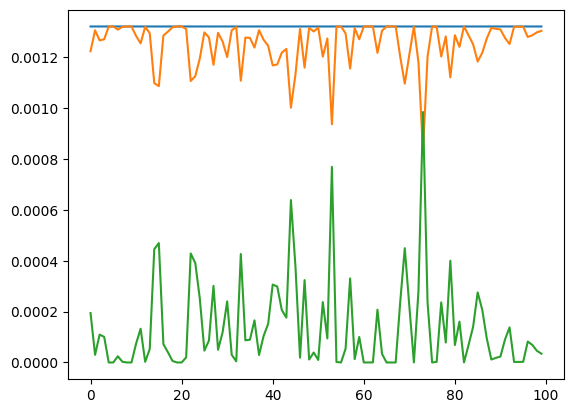

In [296]:
plt.plot(ke + pe / 2)
plt.plot(ke)
plt.plot(pe)

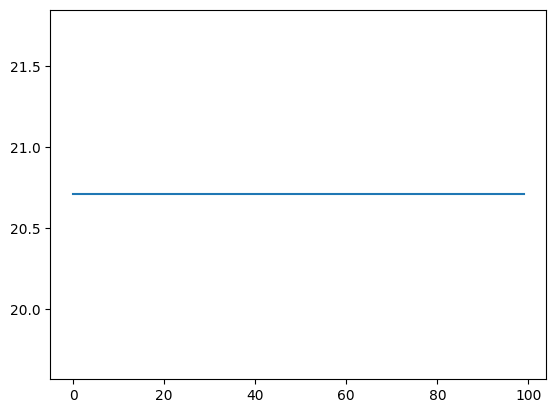

In [239]:
plt.plot(pe)

In [149]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from functools import partial

import vtk
from vtk.util import numpy_support

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def calculate_packing_fraction(state, system):
    volume = jnp.sum(jnp.pi * state.rad ** 2)
    return jnp.sum(volume) / jnp.prod(system.domain.box_size)

def jax_copy(x):
    return jax.tree.map(lambda y: y, x)

def scale_by_packing_fraction_offset(state, system, offset, copy=False):
    """
    Scale the state and system to packing fraction + offset.
    Optionally return a copy of the state and system.
    """
    if copy:
        new_state = jax_copy(state)
        new_system = jax_copy(system)
    else:
        new_state = state
        new_system = system

    packing_fraction = calculate_packing_fraction(new_state, new_system)
    scale = (packing_fraction / (packing_fraction + offset)) ** (1 / state.dim)
    new_state.pos_c *= scale
    new_system.domain.box_size *= scale
    return new_state, new_system

def calculate_kinetic_energy(state):
    """
    Calculate the kinetic energy for each particle.
    """
    ke_t = 0.5 * state.mass * jnp.sum(state.vel ** 2, axis=-1)
    ke_r = 0.5 * jnp.sum(state.inertia * state.angVel ** 2, axis=-1)
    return ke_t + ke_r

def dof_disk(state):  # TODO: account for state.fixed!
    return state.dim * state.N

def dof_rod(state):  # TODO: account for state.fixed!
    return state.dim * state.N + state.inertia.shape[1] * state.N

def dof_rigid_clump(state):  # TODO: account for state.fixed!
    N_clumps = jnp.max(state.ID) + 1
    return state.dim * N_clumps + state.inertia.shape[1] * N_clumps

def calculate_temperature(state, dof_func):
    ke = jnp.sum(calculate_kinetic_energy(state))
    return 2 * ke / dof_func(state)

def set_temperature(state, target_temperature, seed, dof_func, subtract_mean_velocities=True):
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    state.vel = jax.random.normal(key_vel, state.vel.shape)
    if subtract_mean_velocities:
        state.vel -= jnp.mean(state.vel, axis=0)
    state.angVel = jax.random.normal(key_angVel, state.angVel.shape)
    temperature = calculate_temperature(state, dof_func)
    scale = jnp.sqrt(target_temperature / temperature)
    state.vel *= scale
    state.angVel *= scale
    temperature = calculate_temperature(state, dof_func)
    assert jnp.isclose(temperature, target_temperature)
    return state


N_systems = 1
N = 10
phi = 0.4
dim = 2
e_int = 1.0
dt = 1e-2

def build_microstate(i):
    # assign bidisperse radii
    rad = jnp.ones(N)
    rad = rad.at[: N // 2].set(0.5)
    rad = rad.at[N // 2:].set(0.7)
    
    # set the box size for the packing fraction and the radii
    volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
    L = (jnp.sum(volume) / phi) ** (1 / dim)
    box_size = jnp.ones(dim) * L

    # create microstate
    key = jax.random.PRNGKey(np.random.randint(0, 1000000))
    pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
    mass = jnp.ones(N)
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    
    # create system and state
    state = jd.State.create(pos=pos, rad=rad, mass=mass)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="linearfire",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )
    return state, system

T_0 = 1e-5
T_f = 1e-4
N_T = 100

T_vals = np.linspace(T_0, T_f, N_T)

phi_0 = 1e-8
phi_f = 1e-1
N_phi = 10

phi_vals = -np.logspace(np.log10(phi_0), np.log10(phi_f), N_phi)

state, system = build_microstate(0)
ic_state, ic_system, final_pf, final_pe = jd.utils.jamming.bisection_jam(state, system)

ic_system = jd.System.create(
    state_shape=ic_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=ic_system.mat_table,
    domain_kw=dict(
        box_size=ic_system.domain.box_size,
    )
)



Step: 1 -  phi=0.3441187958743684, PE=0.0
Step: 2 -  phi=0.3451187958743684, PE=0.0
Step: 3 -  phi=0.3461187958743684, PE=0.0
Step: 4 -  phi=0.3471187958743684, PE=0.0
Step: 5 -  phi=0.3481187958743684, PE=0.0
Step: 6 -  phi=0.3491187958743684, PE=0.0
Step: 7 -  phi=0.3501187958743684, PE=0.0
Step: 8 -  phi=0.3511187958743684, PE=0.0
Step: 9 -  phi=0.3521187958743684, PE=0.0
Step: 10 -  phi=0.3531187958743684, PE=0.0
Step: 11 -  phi=0.3541187958743684, PE=0.0
Step: 12 -  phi=0.3551187958743684, PE=0.0
Step: 13 -  phi=0.3561187958743684, PE=0.0
Step: 14 -  phi=0.3571187958743684, PE=0.0
Step: 15 -  phi=0.3581187958743684, PE=0.0
Step: 16 -  phi=0.3591187958743684, PE=0.0
Step: 17 -  phi=0.3601187958743684, PE=0.0
Step: 18 -  phi=0.3611187958743684, PE=0.0
Step: 19 -  phi=0.3621187958743684, PE=0.0
Step: 20 -  phi=0.3631187958743684, PE=0.0
Step: 21 -  phi=0.3641187958743684, PE=0.0
Step: 22 -  phi=0.3651187958743684, PE=0.0
Step: 23 -  phi=0.3661187958743684, PE=0.0
Step: 24 -  phi=0.36

In [ ]:
for phi_offset in phi_vals:
    break

base_state = jax_copy(ic_state)
base_system = jax_copy(ic_system)

phi = jnp.sum(jnp.pi * base_state.rad ** 2) / jnp.prod(base_system.domain.box_size)
scale = (phi / (phi + phi_offset)) ** (1 / base_state.dim)
base_state.pos_c *= scale
base_system.domain.box_size *= scale

states = []
systems = []
for T in T_vals:
    state = jax_copy(base_state)
    system = jax_copy(base_system)
    state = set_temperature(state, T, np.random.randint(0, 1e9), dof_disk, True)
    states.append(state)
    systems.append(system)

state = jd.State.stack(states)
system = jd.System.stack(systems)

n_repeats = 1000
ke = np.zeros((n_repeats, state.batch_size))
pe = np.zeros((n_repeats, state.batch_size))
for i in range(n_repeats):
    n_steps = 100
    state, system = system.step(state, system, n=n_steps)
    ke[i] = jnp.sum(0.5 * (state.mass * jnp.sum(state.vel ** 2, axis=-1)), axis=-1)
    pe[i] = 0.5 * jnp.sum(jax.vmap(lambda st, sy: sy.collider.compute_potential_energy(st, sy))(state, system), axis=-1)

temp = 2 * ke / (state.N * state.dim)

te = pe + ke

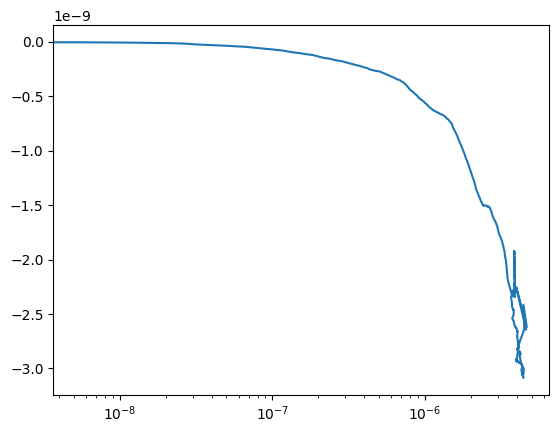

In [141]:
def autocorr(f):
    g = np.zeros(f.size - 1)
    for i in range(1,g.size):
        g[i] = np.mean(f[i:] - f[:-i])
    return g

plt.plot(autocorr(temp[:, 0]), autocorr(te[:, 0]))
plt.xscale('log')

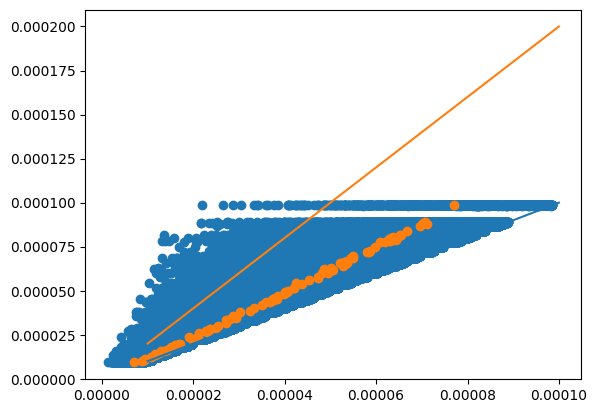

In [128]:
N = state.N
plt.scatter(temp.flatten(), te.flatten() / N)
plt.plot(T_vals, T_vals)
plt.plot(T_vals, T_vals * 2)
plt.scatter(np.mean(temp, axis=0), np.mean(te, axis=0) / N)

# i = 4
# plt.plot(temp[:, i], te[:, i] / N)
# plt.scatter(temp[:, i], temp[:, i])

# i = 8
# plt.plot(temp[:, i], te[:, i])

